In [25]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [26]:
#store midi files as numpy arrays inside dict for easy iteration and look-up
!pip install mido
import os
import mido
import numpy as np

folder_path = 'gdrive/MyDrive/GOLDSMITHS/year 3/dandml/midi_pack'
midi_files = [f for f in os.listdir(folder_path)]
midi_list = []

for file in midi_files:
    sequence = np.zeros((8,8))
    midi = mido.MidiFile(f'{folder_path}/{file}')
    step = 0
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on':
                note = msg.note
                sequence[step%8][(note-4)%8] = 1
                step += 1
            elif msg.type == 'note_off':
                note = msg.note
                sequence[step%8][(note-4)%8] = 0
                step += 1
    midi_list.append(sequence)
print(len(midi_list))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
496


In [27]:
y_train = []
x_train = []

for i, midi in enumerate(midi_list):
  if i % 2 == 0:
    x_train.append(midi)
  elif i % 2 == 1:
    y_train.append(midi)
print(len(x_train))
print(len(y_train))


248
248


In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
test_cap = round((len(x_train) * 0.1))
print(test_cap)

x_test, y_test = x_train[0:test_cap], y_train[0:test_cap]
x_train, y_train = x_train[test_cap:], y_train[test_cap:]
print(len(x_train))
print(len(y_train))

25
223
223


In [30]:
import random
x_augment = []
y_augment = []
for arr in x_train:
  choice = random.randint(1, 3)
  if choice == 1:
    x_augment.append(np.flip(arr))
  elif choice == 2:
    x_augment.append(np.flip(arr, 1))
  elif choice == 3:
    x_augment.append(np.flip(arr, 0))
x_train = np.concatenate((x_train, x_augment))
for arr in y_train:
  choice = random.randint(1, 3)
  if choice == 1:
    y_augment.append(np.flip(arr))
  elif choice == 2:
    y_augment.append(np.flip(arr, 1))
  elif choice == 3:
    y_augment.append(np.flip(arr, 0))

y_train = np.concatenate((y_train, y_augment))

In [50]:
def lstmmodel():
  model = keras.Sequential()
  model.add(layers.Input(shape=(8,8),))
  model.add(layers.LSTM(64, return_sequences=True))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(64))
  model.add(layers.Dense(64))
  model.add(layers.Reshape((8,8)))
  model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
  return model


def rnnmodel():
  model = keras.Sequential()
  model.add(layers.Input(shape=(8,8),))
  model.add(layers.Dense(64))
  model.add(layers.Dropout(0.2))
  model.add(layers.SimpleRNN(64,kernel_regularizer=regularizers.l1(0.02)))
  model.add(layers.Reshape((8,8)))
  model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
  return model

def cnnmodel():
  model = keras.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(4, 4), activation='linear', input_shape=(8, 8, 1)))
  model.add(layers.MaxPooling2D(pool_size=(4, 4)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='linear', kernel_regularizer='l2'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='linear', kernel_regularizer='l2'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Reshape((8,8)))
  model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])


In [53]:
from tensorflow.keras import regularizers

model = lstmmodel()
x_train = np.array(x_train)
y_train = np.array(y_train)

K = 10
num_val_samples = len(x_train) // K
num_epochs = 100
all_acc_histories = []
all_loss_histories = []

for i in range(K):
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    x_val = x_train[a : b]
    y_val = y_train[a : b]
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([x_train[:a], x_train[b:]])
    partial_train_targets = np.concatenate([y_train[:a], y_train[b:]])
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(x_val, y_val),
        epochs=num_epochs, batch_size=64)

    accuracy_history = history.history['val_mae']
    loss_history = history.history['loss']

    all_loss_histories.append(loss_history)
    all_acc_histories.append(loss_history)


Epoch 1/100
7/7 [==============================] - 3s 113ms/step - loss: 0.2691 - mae: 0.3458 - val_loss: 0.2024 - val_mae: 0.3636
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1967 - mae: 0.3641 - val_loss: 0.1842 - val_mae: 0.3460
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1864 - mae: 0.3585 - val_loss: 0.1753 - val_mae: 0.3560
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1836 - mae: 0.3605 - val_loss: 0.1669 - val_mae: 0.3391
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.1830 - mae: 0.3594 - val_loss: 0.1717 - val_mae: 0.3407
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1807 - mae: 0.3557 - val_loss: 0.1678 - val_mae: 0.3420
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1793 - mae: 0.3559 - val_loss: 0.1602 - val_mae: 0.3240
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1783 - mae: 0.3522 - 

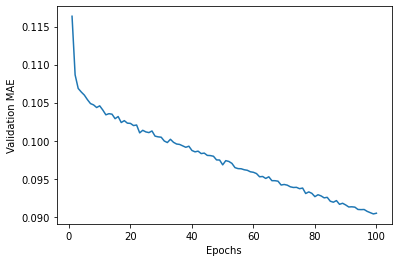

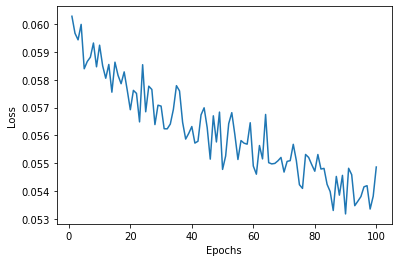

1/1 [==============================] - 0s 62ms/step - loss: 0.2931 - mae: 0.3995
loss — -> 0.2931145429611206
mae — -> 0.39954128861427307


In [55]:
import matplotlib.pyplot as plt
average_acc_history = np.array(all_acc_histories).mean(axis=0)
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

average_loss_history = np.array(all_loss_histories).mean(axis=0)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

x_test = np.array(x_test)
y_test = np.array(y_test)

result = model.evaluate(x_test, y_test)
for i in range(len(result)):
    print(f'{model.metrics_names[i]} — -> {result[i]}')

In [59]:
from keras.models import load_model
from google.colab import files

model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
#using the model to create predictions for the drum model

arr = [[[1., 0., 0., 0., 0., 1., 0., 0.],
  [0., 0., 1., 0., 0., 0., 1., 0.],
  [0., 0., 0., 0., 0., 1., 0., 0.,],
  [0., 0., 0., 0., 0., 0., 1., 0.],
  [0., 0., 0., 0., 0., 1., 0., 0.],
  [0., 0., 0., 0., 0., 0., 0., 1.],
  [0., 0., 0., 0., 0., 1., 0., 0.],
  [0., 0., 0., 0., 0., 0., 0., 1.]]]

myarr = np.array(arr).astype(float)
pred = model.predict(myarr.reshape(1,8,8))

min_val = np.min(pred)
max_val = np.max(pred)
range_val = max_val - min_val
scaled_arr = (pred - min_val) / range_val
print(scaled_arr)
rounded_arr = np.round(scaled_arr)
print(rounded_arr.astype(bool)) 

1/1 [==============================] - 1s 560ms/step
[[[0.41329482 0.32775322 0.84216666 0.0957195  0.12081814 0.26769677
   0.44640708 0.15007299]
  [0.6149401  0.40073922 0.6511085  0.19243881 0.28949037 0.26552656
   0.09087403 0.16792166]
  [0.68197924 0.3493605  1.         0.07196062 0.14632481 0.25666514
   0.5049757  0.290498  ]
  [0.47812954 0.4499293  0.63385683 0.1093605  0.229609   0.2092918
   0.27050593 0.34084865]
  [0.5650112  0.2943843  0.70238465 0.03502068 0.41434816 0.18806459
   0.5121519  0.        ]
  [0.33052447 0.34610382 0.667557   0.12281077 0.3707869  0.02897152
   0.40448496 0.24333376]
  [0.7332578  0.24075657 0.59369344 0.08219738 0.29879212 0.22217843
   0.4865288  0.08102274]
  [0.7595873  0.3919061  0.64770895 0.15272647 0.31170416 0.26400414
   0.28242323 0.06187714]]]
[[[False False  True False False False False False]
  [ True False  True False False False False False]
  [ True False  True False False False  True False]
  [False False  True False Fal